
# PREVISÃO DAS NOTAS DE REDAÇÃO DO ENEM PARA ESCOLAS DA REGIÃO NORTE

As perguntas a serem respondidas neste trabalho serão:


#### 1. Alunos com notas boas em Língua Portuguesa necessariamente terão boas notas em Redação? ####

#### 2. Alunos com notas boas em Matemática terão boas notas em Redação? ####

#### 3. O grupo socioeconômico é um fator que influencia nas notas de Redação? ####

#### 4. A Adequação da Formação Docente é um fator que influencia nas notas de Redação dos alunos? ####




As respostas para tais perguntas serão feitas e comprovadas por meio da análise dos Microdados do Enem por
Escola.


In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [ ]:
vg = pd.read_csv('MICRODADOS_ENEM_ESCOLA.csv', sep = ";", encoding='iso-8859-1')
vg.head()

##  Funções das Regressões Lineares e Polinomiais



In [4]:
def resolveTS(A,b): #A Triangular Superior
    x = np.zeros(len(A))
    soma=0
    j = len(A)-1
    for i in range(len(A)-1,-1, -1):
            while j!= i:
                soma+= A[i][j]*x[j]
                j-=1
            x[j] = (b[i]-soma)/A[i][i]
            soma = 0
            j=len(A)-1
    return x

def resolveTI(A,b): #A Triangular Inferior
    x = np.zeros(len(A))
    soma=0
    j = 0
    for i in range(len(A)):
            while j!= i:
                soma+= A[i][j]*x[j]
                j+=1
            x[i] = (b[i]-soma)/A[i][i]
            soma = 0
            j=0
    return x

def geraCholesky(A):
    L = np.zeros((len(A), len(A)))
    for i in range(len(A)):
        for k in range(i+1): 
            soma = sum(L[i][j]*L[k][j] for j in range(k))
            if i == k:
                L[i][k] = (A[i][i]-soma)**0.5
            else:
                L[i][k] = 1.0/L[k][k]*(A[i][k] - soma)
    return L

In [5]:
def regressaoLinearSimples(x,y):
    b = np.zeros(2)
    soma_x = 0
    soma_y = 0
    soma_xy = 0
    soma_x2 = 0
    for i in range(len(x)):
        soma_x += x[i]
        soma_y += y[i]
        soma_xy += x[i]*y[i]
        soma_x2 += x[i] ** 2
    b[1] = (soma_x*soma_y - len(x)*soma_xy)/(soma_x ** 2 - len(x)*soma_x2)
    b[0] = (soma_y - b[1]*soma_x)/len(x)
    return b

def regressaoLinearMultipla(x,y): #x é uma matriz ao invés de vetor
    matriz_x = np.zeros((len(x)+1, len(x)+1))
    vetor_y = np.zeros(len(matriz_x))
    b = np.zeros(len(matriz_x))
    for i in range(len(matriz_x)):
        if i > 0:
            matriz_x[i][0] = matriz_x[0][i]
        else:
            matriz_x[0][0] = len(x[i])
        for j in range(1,len(matriz_x)):
                if i > 0:
                    matriz_x[i][j] = (x[j-1]*x[i-1]).sum()
                else:
                    matriz_x[i][j] = x[j-1].sum()
                    
    for i in range(len(vetor_y)):
        if i > 0:
            b[i]=(y * x[i-1]).sum()
        else:
            b[i] = y.sum()
    
    matriz_x = geraCholesky(matriz_x)
    vetor_y = resolveTI(matriz_x, b)
    b = resolveTS(matriz_x.transpose(), vetor_y)
    return b

def regressaoPolinomialSimples(x,y, grau):
    matriz_x = np.zeros((grau+1, grau+1))
    vetor_y = np.zeros(len(matriz_x))
    b = np.zeros(len(matriz_x))
    for i in range(len(matriz_x)):
        if i > 0:
            matriz_x[i][0] = matriz_x[0][i]
        else:
            matriz_x[0][0] = len(x)
        for j in range(1,len(matriz_x)):
            if i > 0:
                matriz_x[i][j] = (x ** (j+i)).sum()
            else:
                matriz_x[i][j] = (x ** j).sum()
    for i in range(len(vetor_y)):
        if i > 0:
            b[i]=(y * (x**i)).sum()
        else:
            b[i] = y.sum()
    matriz_x = geraCholesky(matriz_x)
    vetor_y = resolveTI(matriz_x, b)
    b = resolveTS(matriz_x.transpose(), vetor_y)
    return b

def regressaoPolinomialMultipla(x,y, grau): #x é matriz
    matriz_x = np.zeros((len(x)*grau + 1, len(x)*grau + 1))
    vetor_y = np.zeros(len(matriz_x))
    b = np.zeros(len(matriz_x))
    cont_i = -1
    pos_i = 0
    for i in range(len(matriz_x)):
        if cont_i == grau:
            cont_i = 0
            pos_i += 1
            
        pos_j = 0
        cont_j = 0
        cont_i += 1
        
        if i > 0:
            matriz_x[i][0] = matriz_x[0][i]
        else:
            matriz_x[0][0] = len(x[i])
        for j in range(1,len(matriz_x)):
            if i > 0 and cont_j<grau:
                cont_j+=1
                matriz_x[i][j] = ((x[pos_j] ** cont_j) * (x[pos_i] ** cont_i)).sum()
                
            elif i==0 and cont_j<grau:
                cont_j += 1
                matriz_x[i][j]= (x[pos_j] ** cont_j).sum()
                
            if cont_j==grau:
                cont_j = 0
                pos_j+= 1
                
    pos_i = 0
    cont_i = 0
    for i in range(len(vetor_y)):
        if i > 0:
            cont_i+=1
            b[i]=(y * (x[pos_i] ** cont_i)).sum()
            if cont_i == grau:
                cont_i = 0
                pos_i += 1
        else:
            b[i] = y.sum()
    matriz_x = geraCholesky(matriz_x)
    vetor_y = resolveTI(matriz_x, b)
    b = resolveTS(matriz_x.transpose(), vetor_y)
    return b

def resolveLinearSimples(b,x): 
    y=b[0]
    for i in range(1,len(b)):
        y+=b[i]*x
    return y

def resolveLinearMultipla(b,x): #vetor 
    y=b[0]
    for i in range(1,len(b)):
        y+=b[i]*x[i-1]
    return y

def resolvePolinomialSimples(b,x):
    y=b[0]
    for i in range(1,len(b)):
        y+=b[i]*(x**i)
    return y
def resolvePolinomialMultipla(b,x): #vetor
    y = b[0]
    cont = 0
    pos = 0
    for i in range(1,len(b)):                 
        cont+=1
        y+=b[i]*(x[pos] ** cont)
        if cont == ((len(b)-1)/len(x)):
            cont = 0
            pos += 1
    return y




## Funções para o cálculo do Coeficiente de Determinação

In [6]:
def distanciaLinearSimples(b,x,y):
    d=0
    for i in range(len(x)):
        d+= (y[i] - resolveLinearSimples(b,x[i])) ** 2        
    return d
def distanciaLinearMultipla(b,x,y): #matriz
    d=0
    for i in range(len(x[0])):
        d+= (y[i] - resolveLinearMultipla(b,[x1[i] for x1 in x])) ** 2    
    return d
def distanciaPolinomialSimples(b,x,y):
    d=0
    for i in range(len(x)):
        d+= (y[i] - resolvePolinomialSimples(b,x[i])) ** 2        
    return d
def distanciaPolinomialMultipla(b,x,y): #matriz
    d=0
    for i in range(len(x[0])):
        d+= (y[i] - resolvePolinomialMultipla(b,[x1[i] for x1 in x])) ** 2
       
    return d
    
def r2(y, d):
    return (1-(d/((y**2).sum()-(1/len(y)) * (y.sum())** 2)))       





## Regressão Linear Simples

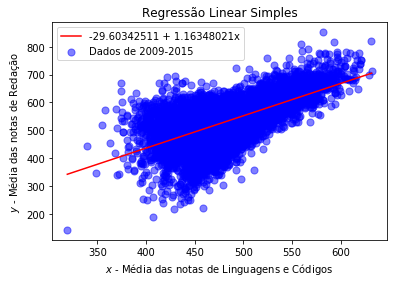

Coeficiente de Determinação = 38.26130413258406 %



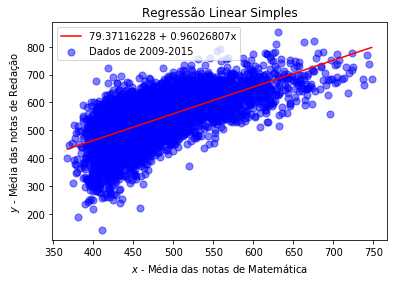

Coeficiente de Determinação = 40.99805069127025 %



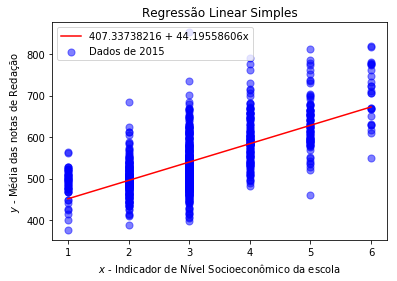

Coeficiente de Determinação = 43.055963247898845 %



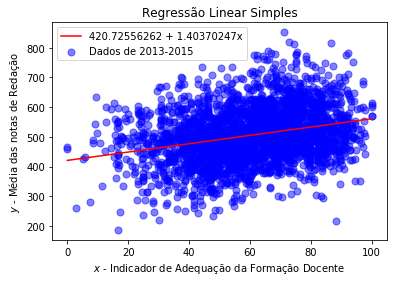

Coeficiente de Determinação = 7.901525770966944 %


In [8]:
x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP #DADOS 2009
x1 = np.array([x1])


y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED
y1 = np.array([y1])


plt.scatter(x1, y1, color='blue', s=50, alpha=.5, label='Dados de 2009-2015')
X_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
plt.plot(X_plot, resolveLinearSimples(regressaoLinearSimples(x1[0], y1[0]),X_plot), color='r', label = '-29.60342511 + 1.16348021x')
plt.title('Regressão Linear Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Média das notas de Linguagens e Códigos')
plt.legend(loc='upper left')
plt.show()

print("Coeficiente de Determinação =",r2(y1[0], distanciaLinearSimples(regressaoLinearSimples(x1[0], y1[0]),x1[0],y1[0]))*100, "%")



print()



x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT #DADOS 2009
x2 = np.array([x2])

y2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED #DADOS 2009
y2 = np.array([y2])


plt.scatter(x2, y2, color='blue', s=50, alpha=.5, label='Dados de 2009-2015')
X_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))
plt.plot(X_plot, resolveLinearSimples(regressaoLinearSimples(x2[0], y2[0]),X_plot), color='r', label = '79.37116228 + 0.96026807x')
plt.title('Regressão Linear Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Média das notas de Matemática')
plt.legend(loc='upper left')
plt.show()
print("Coeficiente de Determinação =",r2(y2[0], distanciaLinearSimples(regressaoLinearSimples(x2[0], y2[0]),x2[0],y2[0]))*100, "%")


print()



x3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE#DADOS 2015
x3 = np.array([x3])

y3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED #DADOS 2015
y3 = np.array([y3])

for i in range(len(x3[0])):
    if(x3[0][i] == 'Grupo 1'):
        x3[0][i] = 1.0
    elif(x3[0][i] == 'Grupo 2'):
        x3[0][i] = 2.0
    elif(x3[0][i] == 'Grupo 3'):
        x3[0][i] = 3.0
    elif(x3[0][i] == 'Grupo 4'):
        x3[0][i] = 4.0
    elif(x3[0][i] == 'Grupo 5'):
        x3[0][i] = 5.0
    elif(x3[0][i] == 'Grupo 6'):
        x3[0][i] = 6.0


plt.scatter(x3, y3, color='blue', s=50, alpha=.5, label='Dados de 2015')
X_plot = np.linspace(min(x3[0]), max(x3[0]), len(x3[0]))
plt.plot(X_plot, resolveLinearSimples(regressaoLinearSimples(x3[0], y3[0]),X_plot), color='r', label = '407.33738216 + 44.19558606x')
plt.title('Regressão Linear Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Indicador de Nível Socioeconômico da escola')
plt.legend(loc='upper left')
plt.show()
print("Coeficiente de Determinação =",r2(y3[0], distanciaLinearSimples(regressaoLinearSimples(x3[0], y3[0]),x3[0],y3[0]))*100, "%")



print()



x4 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.PC_FORMACAO_DOCENTE.notnull()) & (vg.NU_MEDIA_RED.notnull())].PC_FORMACAO_DOCENTE #DADOS 2013
x4 = np.array([x4])

y4 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.PC_FORMACAO_DOCENTE.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED #DADOS 2013
y4 = np.array([y4])


plt.scatter(x4, y4, color='blue', s=50, alpha=.5, label='Dados de 2013-2015')
X_plot = np.linspace(min(x4[0]), max(x4[0]), len(x4[0]))
plt.plot(X_plot, resolveLinearSimples(regressaoLinearSimples(x4[0], y4[0]),X_plot), color='r', label = '420.72556262 + 1.40370247x')
plt.title('Regressão Linear Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Indicador de Adequação da Formação Docente')
plt.legend(loc='upper left')
plt.show()
print("Coeficiente de Determinação =",r2(y4[0], distanciaLinearSimples(regressaoLinearSimples(x4[0], y4[0]),x4[0],y4[0]))*100, "%")


Por meio da Regressão Linear Simples é possível perceber que o Indicador de Nível Socieconômico da escola é a variável independente que mais tem relação com a Média das notas de Redação (variável dependente). Enquanto o Indicador de Adequação da Formação Docente é uma variável independente que tem uma relação muito baixa com a Média das notas de Redação (variável dependente). 

Quanto às Médias das Notas de Matemática e Língua Portuguesa (Linguagens e Códigos), as Notas de Matemática tiveram mais relação com a Média das notas de Redação do que as Notas de Língua Portuguesa para esse modelo.

Como o Indicador de Adequação da Formação Docente é a variável independente de menos relação com a Média das notas de Redação (variável dependente), comparado às demais apresentadas, então não será interessante usá-la como variável independente nas demais regressões.

## Regressão Linear Multipla de 2 variáveis

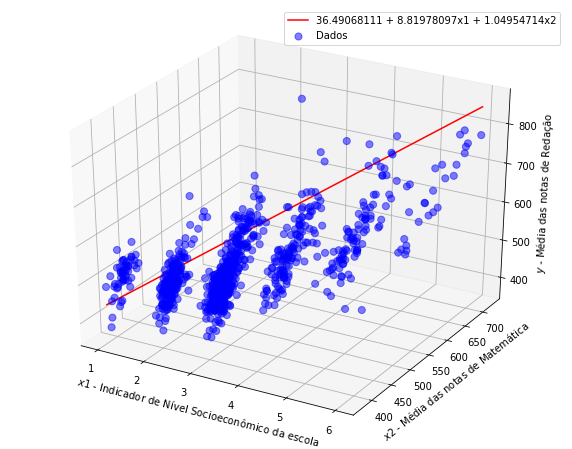

Coeficiente de Determinação = 72.24191829516707 %



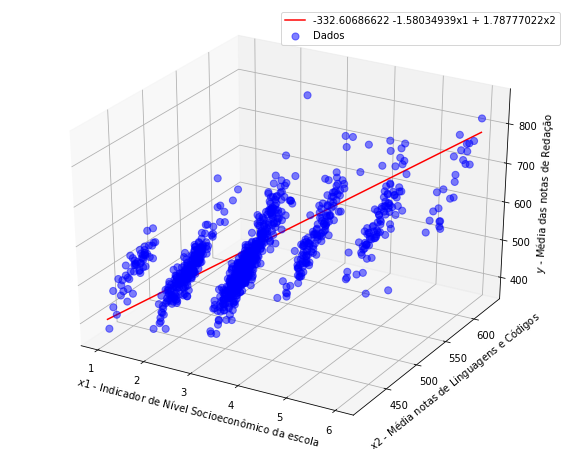

Coeficiente de Determinação = 82.0437674394642 %



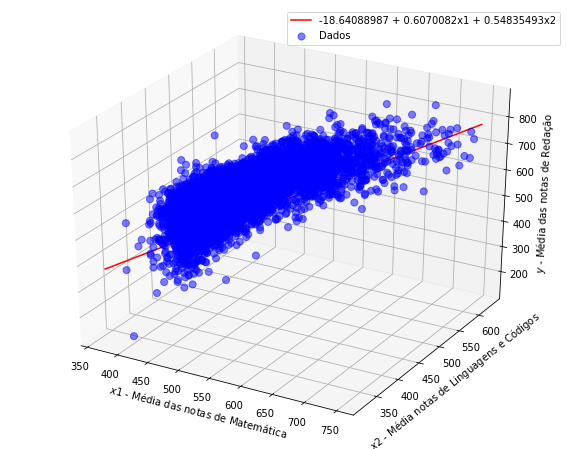

Coeficiente de Determinação = 43.94861245342718 %


In [16]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca(projection='3d')

x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT
x2 = np.array([x2])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0]])

ax.scatter(x1, x2, y1, color='blue', s=50, alpha=.5, label='Dados')
X1_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
X2_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))

b = np.array(regressaoLinearMultipla(matriz,y1[0]))

z = b[0] + b[1] * X1_plot + b[2] * X2_plot
x = -(b[0] + b[2] * X2_plot - z)/b[1]
y = -(b[0] + b[1] * X1_plot -z)/b[2]

ax.plot(x, y, z, color='r',label='36.49068111 + 8.81978097x1 + 1.04954714x2')

ax.set_xlabel('$x1$ - Indicador de Nível Socioeconômico da escola')
ax.set_ylabel('$x2$ - Média das notas de Matemática')
ax.set_zlabel('$y$ - Média das notas de Redação')

#print(regressaoLinearMultipla(matriz,y1[0]))
ax.legend()
plt.show()
print("Coeficiente de Determinação =",r2(y1[0], distanciaLinearMultipla(regressaoLinearMultipla(matriz, y1[0]),matriz,y1[0]))*100, "%")

print()
fig = plt.figure(figsize = (10,8))
ax = fig.gca(projection='3d')

x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP
x2 = np.array([x2])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0]])

ax.scatter(x1, x2, y1, color='blue', s=50, alpha=.5, label='Dados')
X1_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
X2_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))

b = np.array(regressaoLinearMultipla(matriz,y1[0]))

z = b[0] + b[1] * X1_plot + b[2] * X2_plot
x = -(b[0] + b[2] * X2_plot - z)/b[1]
y = -(b[0] + b[1] * X1_plot -z)/b[2]

ax.plot(x, y, z, color='r',label='-332.60686622 -1.58034939x1 + 1.78777022x2')

ax.set_xlabel('$x1$ - Indicador de Nível Socioeconômico da escola')
ax.set_ylabel('$x2$ - Média notas de Linguagens e Códigos')
ax.set_zlabel('$y$ - Média das notas de Redação')

#print(regressaoLinearMultipla(matriz,y1[0]))
ax.legend()
plt.show()
print("Coeficiente de Determinação =",r2(y1[0], distanciaLinearMultipla(regressaoLinearMultipla(matriz, y1[0]),matriz,y1[0]))*100, "%")

print()
fig = plt.figure(figsize = (10,8))
ax = fig.gca(projection='3d')

x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP
x2 = np.array([x2])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0]])

ax.scatter(x1, x2, y1, color='blue', s=50, alpha=.5, label='Dados')
X1_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
X2_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))

b = np.array(regressaoLinearMultipla(matriz,y1[0]))

z = b[0] + b[1] * X1_plot + b[2] * X2_plot
x = -(b[0] + b[2] * X2_plot - z)/b[1]
y = -(b[0] + b[1] * X1_plot -z)/b[2]

ax.plot(x, y, z, color='r',label='-18.64088987 + 0.6070082x1 + 0.54835493x2')

ax.set_xlabel('$x1$ - Média das notas de Matemática')
ax.set_ylabel('$x2$ - Média notas de Linguagens e Códigos')
ax.set_zlabel('$y$ - Média das notas de Redação')

#print(regressaoLinearMultipla(matriz,y1[0]))
ax.legend()
plt.show()
print("Coeficiente de Determinação =",r2(y1[0], distanciaLinearMultipla(regressaoLinearMultipla(matriz, y1[0]),matriz,y1[0]))*100, "%")



Por meio da Regressão Linear Multipla de 2 variáveis é comprovado novamente que o Indicador de Nível Socioeconômico da escola é o fator que mais influencia nas Médias das Notas de Redação, se comparado com os demais fatores apresentados. 

Relacionando as variáveis independentes Média das notas de Matemática e Média das notas de Língua Portuguesa (Linguagens e Códigos) com a variável dependente Média das notas de redação não se nota grandes mudanças significativas no valor do Coeficiente de Determinação, se comparado aos Coeficientes de Determinação da Regressão Linear Simples. Porém, ao pôr o Indicador de Nível Socioeconômico como uma das variáveis independentes esse Coeficiente sofre mudanças significativas no seu valor, no caso o modelo se aproxima mais da "perfeição" (o Coeficiente passa a possuir um valor maior).

Ao contrário da Regressão Linear Simples e considerando o Indicador de Nível Socioeconômico como uma das variáveis independentes, a Média das notas de Língua Portuguesa teve mais relação com a Média das notas de Redação do que a Média das notas de Matemática.

## Regressão Linear Multipla de 3 variáveis

In [228]:
x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT
x2 = np.array([x2])

x3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP
x3 = np.array([x3])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0], x3[0]])

b = np.array(regressaoLinearMultipla(matriz,y1[0]))

print("y=",b[0], b[1],"x1 +",b[2],"x2 +",b[3],"x3")
print("Coeficiente de Determinação =",r2(y1[0], distanciaLinearMultipla(regressaoLinearMultipla(matriz, y1[0]),matriz,y1[0]))*100, "%")




y= -300.0609323416382 -2.7582425090692473 x1 + 0.2693830207829392 x2 + 1.479164165117204 x3
Coeficiente de Determinação = 82.80470840666621 %


Relacionando a Média das Notas de Matemática, a Média das Notas de Língua Portuguesa e o Indicador Socioeconômico da escola com a Média das Notas de Redação temos o maior valor do Coeficiente de Determinação até agora, o que significa que entre o modelo de Regressão Linear Simples, de Regressão Linear Múltipla de 2 variáveis e de Regressão Linear Multipla de 3 variáveis o modelo de Regressão Linear Multipla de 3 variáveis é o mais condizente com os dados em questão.

## Regressão Polinomial Simples de 2° grau

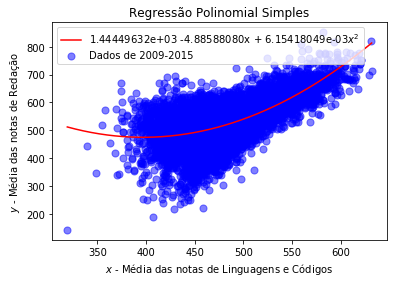

Coeficiente de Determinação = 41.94955675635064 %



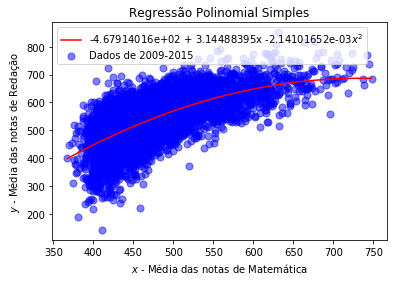

Coeficiente de Determinação = 42.428462259213184 %



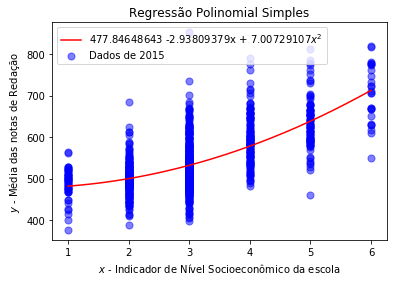

Coeficiente de Determinação = 45.696191677359145 %


In [236]:
x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP #DADOS 2009
x1 = np.array([x1])


y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED
y1 = np.array([y1])


plt.scatter(x1, y1, color='blue', s=50, alpha=.5, label='Dados de 2009-2015')
X_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
plt.plot(X_plot, resolvePolinomialSimples(regressaoPolinomialSimples(x1[0], y1[0],2),X_plot), color='r', label = '1.44449632e+03 -4.88588080x + 6.15418049e-03$x^2$')
plt.title('Regressão Polinomial Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Média das notas de Linguagens e Códigos')
plt.legend(loc='upper left')
plt.show()
#print(regressaoPolinomialSimples(x1[0], y1[0],2))
print("Coeficiente de Determinação =",r2(y1[0], distanciaPolinomialSimples(regressaoPolinomialSimples(x1[0], y1[0],2),x1[0],y1[0]))*100, "%")



print()



x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT #DADOS 2009
x2 = np.array([x2])

y2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED #DADOS 2009
y2 = np.array([y2])


plt.scatter(x2, y2, color='blue', s=50, alpha=.5, label='Dados de 2009-2015')
X_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))
plt.plot(X_plot, resolvePolinomialSimples(regressaoPolinomialSimples(x2[0], y2[0],2),X_plot), color='r', label = '-4.67914016e+02 + 3.14488395x -2.14101652e-03$x^2$')
plt.title('Regressão Polinomial Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Média das notas de Matemática')
plt.legend(loc='upper left')
plt.show()
#print(regressaoPolinomialSimples(x2[0], y2[0],2))
print("Coeficiente de Determinação =",r2(y2[0], distanciaPolinomialSimples(regressaoPolinomialSimples(x2[0], y2[0],2),x2[0],y2[0]))*100, "%")


print()



x3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE#DADOS 2015
x3 = np.array([x3])

y3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED #DADOS 2015
y3 = np.array([y3])

for i in range(len(x3[0])):
    if(x3[0][i] == 'Grupo 1'):
        x3[0][i] = 1.0
    elif(x3[0][i] == 'Grupo 2'):
        x3[0][i] = 2.0
    elif(x3[0][i] == 'Grupo 3'):
        x3[0][i] = 3.0
    elif(x3[0][i] == 'Grupo 4'):
        x3[0][i] = 4.0
    elif(x3[0][i] == 'Grupo 5'):
        x3[0][i] = 5.0
    elif(x3[0][i] == 'Grupo 6'):
        x3[0][i] = 6.0


plt.scatter(x3, y3, color='blue', s=50, alpha=.5, label='Dados de 2015')
X_plot = np.linspace(min(x3[0]), max(x3[0]), len(x3[0]))
plt.plot(X_plot, resolvePolinomialSimples(regressaoPolinomialSimples(x3[0], y3[0],2),X_plot), color='r', label = '477.84648643 -2.93809379x + 7.00729107$x^2$')
plt.title('Regressão Polinomial Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Indicador de Nível Socioeconômico da escola')
plt.legend(loc='upper left')
plt.show()

print("Coeficiente de Determinação =",r2(y3[0], distanciaPolinomialSimples(regressaoPolinomialSimples(x3[0], y3[0],2),x3[0],y3[0]))*100, "%")
#print(regressaoPolinomialSimples(x3[0], y3[0],2))

## Regressão Polinomial Simples de 3° grau

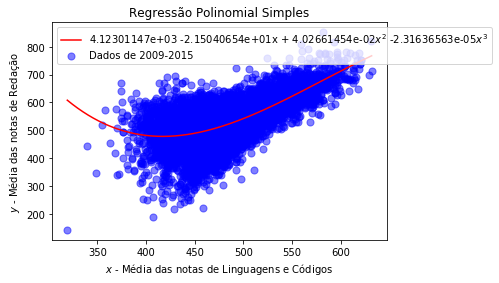

Coeficiente de Determinação = 42.20487129766893 %



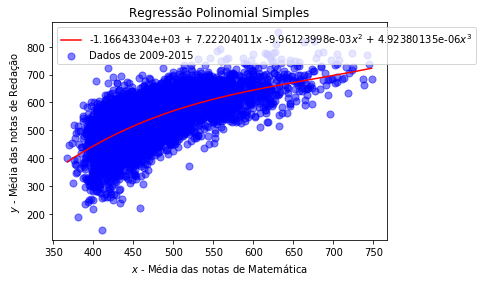

Coeficiente de Determinação = 42.49891186403302 %



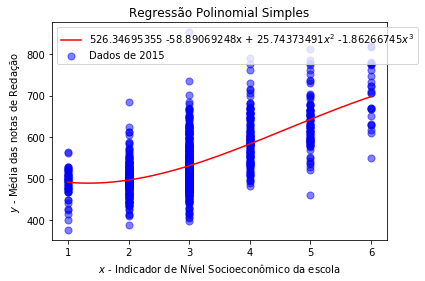

Coeficiente de Determinação = 46.059157144647955 %


In [11]:
x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP #DADOS 2009
x1 = np.array([x1])


y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED
y1 = np.array([y1])


plt.scatter(x1, y1, color='blue', s=50, alpha=.5, label='Dados de 2009-2015')
X_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
plt.plot(X_plot, resolvePolinomialSimples(regressaoPolinomialSimples(x1[0], y1[0],3),X_plot), color='r', label = '4.12301147e+03 -2.15040654e+01x + 4.02661454e-02$x^2$ -2.31636563e-05$x^3$')
plt.title('Regressão Polinomial Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Média das notas de Linguagens e Códigos')
plt.legend(loc='upper left')
plt.show()
#print(regressaoPolinomialSimples(x1[0], y1[0],3))
print("Coeficiente de Determinação =",r2(y1[0], distanciaPolinomialSimples(regressaoPolinomialSimples(x1[0], y1[0],3),x1[0],y1[0]))*100, "%")



print()



x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT #DADOS 2009
x2 = np.array([x2])

y2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED #DADOS 2009
y2 = np.array([y2])


plt.scatter(x2, y2, color='blue', s=50, alpha=.5, label='Dados de 2009-2015')
X_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))
plt.plot(X_plot, resolvePolinomialSimples(regressaoPolinomialSimples(x2[0], y2[0],3),X_plot), color='r', label = '-1.16643304e+03 + 7.22204011x -9.96123998e-03$x^2$ + 4.92380135e-06$x^3$')
plt.title('Regressão Polinomial Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Média das notas de Matemática')
plt.legend(loc='upper left')
plt.show()
#print(regressaoPolinomialSimples(x2[0], y2[0],3))
print("Coeficiente de Determinação =",r2(y2[0], distanciaPolinomialSimples(regressaoPolinomialSimples(x2[0], y2[0],3),x2[0],y2[0]))*100, "%")


print()



x3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE#DADOS 2015
x3 = np.array([x3])

y3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED #DADOS 2015
y3 = np.array([y3])

for i in range(len(x3[0])):
    if(x3[0][i] == 'Grupo 1'):
        x3[0][i] = 1.0
    elif(x3[0][i] == 'Grupo 2'):
        x3[0][i] = 2.0
    elif(x3[0][i] == 'Grupo 3'):
        x3[0][i] = 3.0
    elif(x3[0][i] == 'Grupo 4'):
        x3[0][i] = 4.0
    elif(x3[0][i] == 'Grupo 5'):
        x3[0][i] = 5.0
    elif(x3[0][i] == 'Grupo 6'):
        x3[0][i] = 6.0


plt.scatter(x3, y3, color='blue', s=50, alpha=.5, label='Dados de 2015')
X_plot = np.linspace(min(x3[0]), max(x3[0]), len(x3[0]))
plt.plot(X_plot, resolvePolinomialSimples(regressaoPolinomialSimples(x3[0], y3[0],3),X_plot), color='r', label = '526.34695355 -58.89069248x + 25.74373491$x^2$ -1.86266745$x^3$')
plt.title('Regressão Polinomial Simples')
plt.ylabel('$y$ - Média das notas de Redação')
plt.xlabel('$x$ - Indicador de Nível Socioeconômico da escola')
plt.legend(loc='upper left')
plt.show()

print("Coeficiente de Determinação =",r2(y3[0], distanciaPolinomialSimples(regressaoPolinomialSimples(x3[0], y3[0],3),x3[0],y3[0]))*100, "%")
#print(regressaoPolinomialSimples(x3[0], y3[0],3))

Se comparar os Coeficientes de Determinação da Regressão Linear Simples com os da Regressão Polinomial Simples notam-se mudanças no seu valor, no caso ele é maior para esses modelos de Regressão Polinomial Simples. Porém, os Coeficientes da Regressão Polinomial Simples não superaram os valores do Coeficiente da Regressão Linear Multipla de 3 variáveis, portanto esse último modelo continua sendo o melhor para a previsão dos dados.

## Regressão Polinomial Multipla de 2 variáveis e de 2° grau

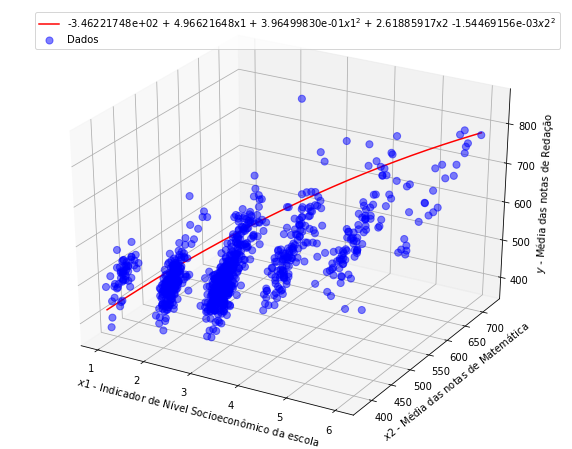

Coeficiente de Determinação = 73.07892175366916 %



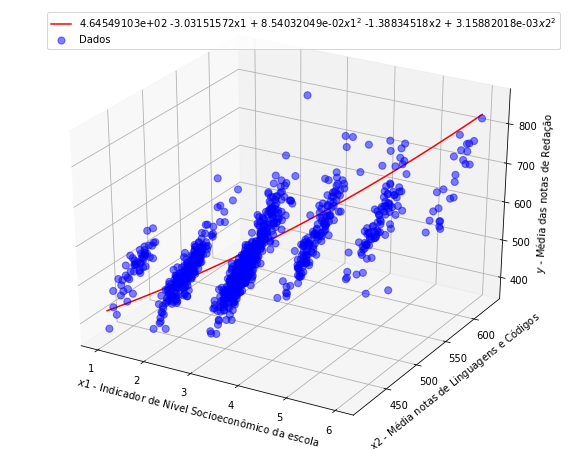

Coeficiente de Determinação = 82.67262504783766 %



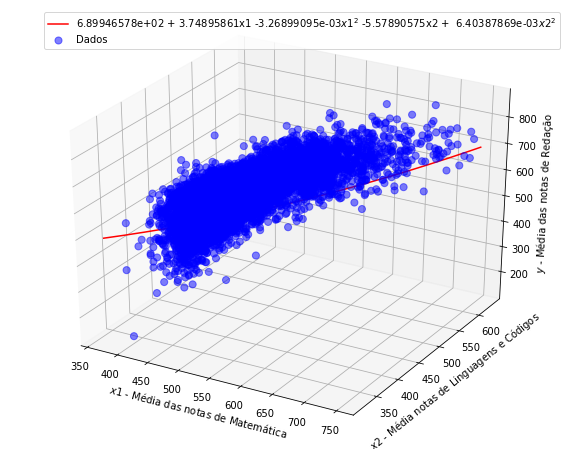

Coeficiente de Determinação = 47.21424515743148 %


In [17]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca(projection='3d')


x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT
x2 = np.array([x2])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0]])

ax.scatter(x1, x2, y1, color='blue', s=50, alpha=.5, label='Dados')
X1_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
X2_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))

b = np.array(regressaoPolinomialMultipla(matriz,y1[0],2))

z = b[0] + b[1] * X1_plot + b[2] * (X1_plot **2) + b[3] * X2_plot + b[4] * (X2_plot**2)
x = -(b[0] + b[3] * X2_plot + b[4] * (X2_plot ** 2) - z)/(b[1] + b[2] * X1_plot)
y = -(b[0] + b[1] * X1_plot + b[2] * (X1_plot ** 2) - z)/(b[3] + b[4] * X2_plot)

ax.plot(x, y, z, color='r',label='-3.46221748e+02 + 4.96621648x1 + 3.96499830e-01$x1^2$ + 2.61885917x2 -1.54469156e-03$x2^2$')

ax.set_xlabel('$x1$ - Indicador de Nível Socioeconômico da escola')
ax.set_ylabel('$x2$ - Média das notas de Matemática')
ax.set_zlabel('$y$ - Média das notas de Redação')

#print(regressaoPolinomialMultipla(matriz,y1[0],2))
ax.legend()
plt.show()
print("Coeficiente de Determinação =",r2(y1[0], distanciaPolinomialMultipla(regressaoPolinomialMultipla(matriz, y1[0],2),matriz,y1[0]))*100, "%")

print()
fig = plt.figure(figsize = (10,8))
ax = fig.gca(projection='3d')

x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP
x2 = np.array([x2])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0]])

ax.scatter(x1, x2, y1, color='blue', s=50, alpha=.5, label='Dados')
X1_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
X2_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))

b = np.array(regressaoPolinomialMultipla(matriz,y1[0],2))

z = b[0] + b[1] * X1_plot + b[2] * (X1_plot **2) + b[3] * X2_plot + b[4] * (X2_plot**2)
x = -(b[0] + b[3] * X2_plot + b[4] * (X2_plot ** 2) - z)/(b[1] + b[2] * X1_plot)
y = -(b[0] + b[1] * X1_plot + b[2] * (X1_plot ** 2) - z)/(b[3] + b[4] * X2_plot)

ax.plot(x, y, z, color='r',label='4.64549103e+02 -3.03151572x1 + 8.54032049e-02$x1^2$ -1.38834518x2 + 3.15882018e-03$x2^2$')

ax.set_xlabel('$x1$ - Indicador de Nível Socioeconômico da escola')
ax.set_ylabel('$x2$ - Média notas de Linguagens e Códigos')
ax.set_zlabel('$y$ - Média das notas de Redação')

#print(regressaoPolinomialMultipla(matriz,y1[0],2))
ax.legend()
plt.show()
print("Coeficiente de Determinação =",r2(y1[0], distanciaPolinomialMultipla(regressaoPolinomialMultipla(matriz, y1[0],2),matriz,y1[0]))*100, "%")

print()
fig = plt.figure(figsize = (10,8))
ax = fig.gca(projection='3d')

x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP
x2 = np.array([x2])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0]])

ax.scatter(x1, x2, y1, color='blue', s=50, alpha=.5, label='Dados')
X1_plot = np.linspace(min(x1[0]), max(x1[0]), len(x1[0]))
X2_plot = np.linspace(min(x2[0]), max(x2[0]), len(x2[0]))

b = np.array(regressaoPolinomialMultipla(matriz,y1[0],2))

z = b[0] + b[1] * X1_plot + b[2] * (X1_plot **2) + b[3] * X2_plot + b[4] * (X2_plot**2)
x = -(b[0] + b[3] * X2_plot + b[4] * (X2_plot ** 2) - z)/(b[1] + b[2] * X1_plot)
y = -(b[0] + b[1] * X1_plot + b[2] * (X1_plot ** 2) - z)/(b[3] + b[4] * X2_plot)

ax.plot(x, y, z, color='r',label='6.89946578e+02 + 3.74895861x1 -3.26899095e-03$x1^2$ -5.57890575x2 +  6.40387869e-03$x2^2$')

ax.set_xlabel('$x1$ - Média das notas de Matemática')
ax.set_ylabel('$x2$ - Média notas de Linguagens e Códigos')
ax.set_zlabel('$y$ - Média das notas de Redação')

#print(regressaoPolinomialMultipla(matriz,y1[0],2))
ax.legend()
plt.show()
print("Coeficiente de Determinação =",r2(y1[0], distanciaPolinomialMultipla(regressaoPolinomialMultipla(matriz, y1[0],2),matriz,y1[0]))*100, "%")


Para o primeiro gráfico, o Coeficiente de Determinação possui um valor menor do que o da Regressão Linear Multipla de 2 variáveis. Já para o segundo e terceiro gráficos os Coeficientes possuem valores maiores do que os da Linear Multipla de 2 variáveis. Porém não são mudanças de grande significância e também nenhum dos Coeficientes superaram o valor do Coeficiente de Determinação da Regressão Linear Multipla de 3 variáveis, portanto esse último modelo continua sendo o melhor para a previsão dos dados.

## Regressão Polinomial Multipla de 3 variáveis e de 2° grau

In [22]:
x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT
x2 = np.array([x2])

x3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP
x3 = np.array([x3])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0], x3[0]])

b = np.array(regressaoPolinomialMultipla(matriz,y1[0],2))

print("y=",b[0], b[1],"x1 +",b[2],"x1^2 +",b[3],"x2 +", b[4],"x2^2 +", b[5],"x3 +", b[6],"x3^2")
print("Coeficiente de Determinação =",r2(y1[0], distanciaPolinomialMultipla(regressaoPolinomialMultipla(matriz, y1[0],2),matriz,y1[0]))*100, "%")

print()





y= 100.96303295532401 -3.2061338314820125 x1 + 0.051269733473640236 x1^2 + 0.01898011445412743 x2 + 0.00017397095619589592 x2^2 + 0.10040136920897426 x3 + 0.0014611307567321645 x3^2
Coeficiente de Determinação = 82.94500991760476 %



## Regressão Polinomial Multipla de 3 variáveis e de 3° grau

In [26]:
x1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].INSE
x1 = np.array([x1])

x2 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_MT
x2 = np.array([x2])

x3 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_LP
x3 = np.array([x3])

y1 = vg[((vg.SG_UF_ESCOLA ==  'AM') | (vg.SG_UF_ESCOLA ==  'RO') | (vg.SG_UF_ESCOLA ==  'AC') | (vg.SG_UF_ESCOLA ==  'RR') | (vg.SG_UF_ESCOLA ==  'PA') | (vg.SG_UF_ESCOLA ==  'AP') | (vg.SG_UF_ESCOLA ==  'TO') ) & (vg.INSE.notnull()) & (vg.NU_MEDIA_MT.notnull()) & (vg.NU_MEDIA_LP.notnull()) & (vg.NU_MEDIA_RED.notnull())].NU_MEDIA_RED 
y1 = np.array([y1])

for i in range(len(x1[0])):
    if(x1[0][i] == 'Grupo 1'):
        x1[0][i] = 1.0
    elif(x1[0][i] == 'Grupo 2'):
        x1[0][i] = 2.0
    elif(x1[0][i] == 'Grupo 3'):
        x1[0][i] = 3.0
    elif(x1[0][i] == 'Grupo 4'):
        x1[0][i] = 4.0
    elif(x1[0][i] == 'Grupo 5'):
        x1[0][i] = 5.0
    elif(x1[0][i] == 'Grupo 6'):
        x1[0][i] = 6.0
        
matriz = np.array([x1[0], x2[0], x3[0]])

b = np.array(regressaoPolinomialMultipla(matriz,y1[0],3))

print("y=",b[0], b[1],"x1",b[2],"x1^2 +",b[3],"x1^3", b[4],"x2 +", b[5],"x2^2", b[6],"x2^3", b[7],"x3 +", b[8], "x3^2",b[9], "x3^3")
print("Coeficiente de Determinação =",r2(y1[0], distanciaPolinomialMultipla(regressaoPolinomialMultipla(matriz, y1[0],3),matriz,y1[0]))*100, "%")


y= 3770.9554809459514 -1.9336481639229592 x1 -0.35107729650102387 x1^2 + 0.02696374235895208 x1^3 -8.664083551365337 x2 + 0.01642761327366031 x2^2 -9.901235995437609e-06 x2^3 -13.544018821900965 x3 + 0.030030695491778198 x3^2 -1.9798165220455135e-05 x3^3
Coeficiente de Determinação = 83.31147237546224 %


A Regressão Polinomial de 3 variáveis e de 3° grau foi o modelo que apresentou o maior valor para o Coeficiente de Determinação ($R2 =$ 83.31147237546224%). Isso significa que para todos os modelos de Regressões feitos, esse modelo de Regressão Polinomial de 3 variáveis e de 3° grau é o mais condizente com os dados em questão para as variáveis analisadas. Portanto, a equação mais adequada para a previsão dos dados é:

$y = 3770.9554809459514 - 1.9336481639229592x1 - 0.35107729650102387x1^2 + 0.02696374235895208x1^3 - 8.664083551365337x2 + 0.01642761327366031x2^2 - 9.901235995437609e-06x2^3 - 13.544018821900965x3 + 0.030030695491778198x3^2 - 1.9798165220455135e-05x3^3$

## Considerações Finais

Analisando os dados por meio das Regressões Lineares e Polinomiais, observamos que dentre todas as variáveis independentes utilizadas o Indicador Socioeconômico da Escola é a que mais influencia na Média das Notas de Redação. Para visualizar melhor essa distribuição podemos comparar todos os grupos socioeconômicos por meio de um histograma:


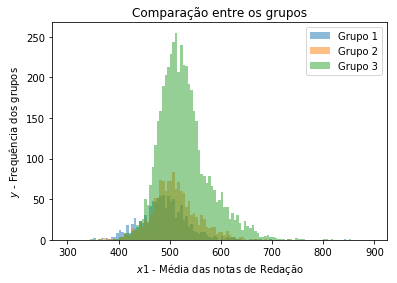

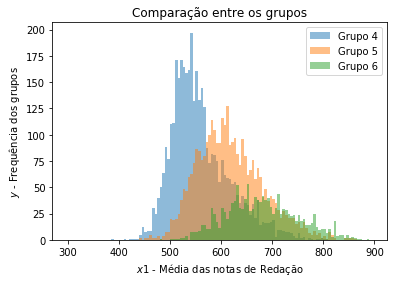

In [27]:
pd.crosstab(vg.INSE,vg.NU_MEDIA_RED,margins = True)
bins = list(range(300,900,5))
vgval = vg[(vg.NU_MEDIA_RED.notnull())] 

plt.hist(vgval[vgval.INSE=='Grupo 1'].NU_MEDIA_RED,bins,alpha=0.5,label='Grupo 1')
plt.hist(vgval[vgval.INSE=='Grupo 2'].NU_MEDIA_RED,bins,alpha=0.5,label='Grupo 2')
plt.hist(vgval[vgval.INSE=='Grupo 3'].NU_MEDIA_RED,bins,alpha=0.5,label='Grupo 3')

x = vgval[vgval.INSE=='Grupo 3'].NU_MEDIA_RED
for i in range(len(x)): 
    y = x.value_counts()
y = np.array([y])
x = np.array([x])

plt.title('Comparação entre os grupos')
plt.ylabel('$y$ - Frequência dos grupos')
plt.xlabel('$x1$ - Média das notas de Redação')

plt.legend()
plt.show()

print()

plt.hist(vgval[vgval.INSE=='Grupo 4'].NU_MEDIA_RED,bins,alpha=0.5,label='Grupo 4')
plt.hist(vgval[vgval.INSE=='Grupo 5'].NU_MEDIA_RED,bins,alpha=0.5,label='Grupo 5')
plt.hist(vgval[vgval.INSE=='Grupo 6'].NU_MEDIA_RED,bins,alpha=0.5,label='Grupo 6')
plt.title('Comparação entre os grupos')
plt.ylabel('$y$ - Frequência dos grupos')
plt.xlabel('$x1$ - Média das notas de Redação')
plt.legend()
plt.show()

De fato, analisando os histogramas fica evidente que classes menos favorecidas tendem a tirar notas menores na Redação, enquanto as mais favorecidas tendem a tirar notas maiores.

## Conclusões

Por meio da análise dos dados, conclui-se que:
1. Alunos com boas notas em Língua Portuguesa tendem a tirar boas notas em Redação também;
2. Alunos com boas notas em Matemática tendem a tirar boas notas em Redação;
3. Dentre as variáveis analisadas, o grupo socioeconômico é o maior influenciador na Média das Notas de Redação;
4. A Adequação da Formação Docente não se mostrou um fator de grande influência sobre a Média das Notas de Redação.